### Data Reading and Preprocessing

CSO website is providing data in different formats. CSV format is the most common import and export format for spreadsheets and databases. However, for current analysis I will use data in JSON.stat format. 

Official documentation on how to read and download the data via API from CSO available here.

https://github.com/CSOIreland/PxStat/wiki/API-Cube-PxAPIv1

In [1]:
#downloading the data in JSON.stat

by_month = 'https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.PxAPIv1/en/46/RSARS/ROA17?query=%7B%22query%22:%5B%5D,%22response%22:%7B%22format%22:%22json-stat2%22,%22pivot%22:null,%22codes%22:false%7D%7D'

JSON represents objects as name/value pairs, just like a Python dictionary. The JSON-stat format is a simple lightweight JSON format for data dissemination. 
pyjstat is a python library for JSON-stat formatted data, which allows reading and writing JSON-stat easily.

https://pypi.org/project/pyjstat/

In [147]:
#installing pyjstat
!pip install pyjstat

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
#Importing necessary libraries
from pyjstat import pyjstat #JSON reading
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra
import seaborn as sns # Visualization
import matplotlib.pyplot as plot # Visualization
from sklearn.metrics import mean_absolute_error, mean_squared_error #statistic
import math #for math operations
import warnings # Supress warnings 
warnings.filterwarnings('ignore')
import pandas as pd # data processing
import numpy as np # linear algebra

In [4]:
#Parsing JSON to dataset
dataset = pyjstat.Dataset.read(by_month)

In [5]:
# Creating pandas data frame from available dataset
dfm = dataset.write('dataframe')
dfm.head()

,Statistic,Year,Month of Year,value
0,Fatal Collisions,2005,All months,360.0
1,Fatal Collisions,2005,January,31.0
2,Fatal Collisions,2005,February,34.0
3,Fatal Collisions,2005,March,23.0
4,Fatal Collisions,2005,April,20.0


At first glance we can see that there is "All months" value in the list of months. In order to keep omogenity of the data this value needs to be dropped.

In [6]:
dfm = dfm.drop(dfm[(dfm['Month of Year'] == 'All months')].index) #impact omogenity of the data
dfm = dfm.reset_index(drop=True)

In [7]:
#Checking data types and null values
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Statistic      1224 non-null   object 
 1   Year           1224 non-null   object 
 2   Month of Year  1224 non-null   object 
 3   value          1223 non-null   float64
dtypes: float64(1), object(3)
memory usage: 38.4+ KB


In [8]:
# There is 1 null value. let's examine it and decide how to handle it
row_with_na = dfm[dfm.isna().any(axis=1)]
row_with_na

,Statistic,Year,Month of Year,value
1211,All Killed and Injured Casualties,2020,December,NaN


In [9]:
filtered_df = dfm[(dfm['Statistic'] == 'All Killed and Injured Casualties') & (dfm['Year'] == '2020')]
dfm = dfm.fillna(dfm[['value']].mean())
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Statistic      1224 non-null   object 
 1   Year           1224 non-null   object 
 2   Month of Year  1224 non-null   object 
 3   value          1224 non-null   float64
dtypes: float64(1), object(3)
memory usage: 38.4+ KB


Dataframe has 3 categorical data: 'Year','Month of Year', 'Statistic' and 1 numerican with 1 missing value. Let's inspect them 1 by 1.

In [10]:
dfm.Year.unique()

array(['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021'], dtype=object)

In [11]:
dfm['Month of Year'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

In [12]:
#To work with 'Year' and 'Month of Year' as date let's transform them into date format.
dfm['Date'] = dfm['Year'] + '-' + dfm['Month of Year']
dfm['Date'] = pd.to_datetime(dfm['Date'],infer_datetime_format=True) #convert from string to datetime
dfm = dfm.drop(columns=['Year', 'Month of Year'])

In [13]:
#Inspecting rest of categorical data
labels = dfm.Statistic.unique()
labels

array(['Fatal Collisions', 'Injury Collisions',
       'All Fatal and Injury Collisions', 'Killed Casualties',
       'Injured Casualties', 'All Killed and Injured Casualties'],
      dtype=object)

In [14]:
# To explore available trends, dependencies and create a deep understanding of available data.
# let's move data from rows to columns by using groupby and unstack
grouped = dfm.groupby(['Date', 'Statistic'])['value'].sum().unstack()
grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2005-01-01 to 2021-12-01
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   All Fatal and Injury Collisions    204 non-null    float64
 1   All Killed and Injured Casualties  204 non-null    float64
 2   Fatal Collisions                   204 non-null    float64
 3   Injured Casualties                 204 non-null    float64
 4   Injury Collisions                  204 non-null    float64
 5   Killed Casualties                  204 non-null    float64
dtypes: float64(6)
memory usage: 11.2 KB


## EDA
### Visualisation & Descriptive statistic

At this stage we already have omogen data with same number of observation for each feature

In [15]:
# Obtain the descriptive (summary) statistics
grouped.describe()

Statistic,All Fatal and Injury Collisions,All Killed and Injured Casualties,Fatal Collisions,Injured Casualties,Injury Collisions,Killed Casualties
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,479.470588,674.926495,16.274510,658.406863,463.196078,17.754902
std,74.326030,125.302138,7.192849,119.661205,71.919638,8.127599
min,139.000000,166.000000,3.000000,159.000000,132.000000,3.000000
25%,445.000000,610.000000,11.000000,596.750000,426.750000,12.000000
50%,484.500000,680.000000,15.000000,661.000000,468.500000,16.000000
75%,527.500000,743.250000,19.000000,725.250000,509.000000,21.000000
max,628.000000,995.000000,38.000000,976.000000,611.000000,44.000000


#Let's work with average data to check proportions by using visualisation:
1. Fatal and Injury Collisions 
2. Killed and Injured Casualties
3. All Fatal and Injury Collisions with Killed Casualties

In [16]:
mean_values = grouped.mean()
mean_values

Statistic
All Fatal and Injury Collisions      479.470588
All Killed and Injured Casualties    674.926495
Fatal Collisions                      16.274510
Injured Casualties                   658.406863
Injury Collisions                    463.196078
Killed Casualties                     17.754902
dtype: float64

In [17]:
from scipy.stats import shapiro

# perform and verify Shapiro Test to check normality for our data

#H0: data comes from normal distribution
#H1: data does not come from normal distribution

# Performing Shapiro-Wilk test for each column
shapiro_results = {}
for column in labels:
    stat, p = shapiro(grouped[column])
    shapiro_results[column] = {'Statistic': "{:.3f}".format(stat), 'p-value':"{:.2f}".format(p)}

shapiro_results_df = pd.DataFrame(shapiro_results).T
shapiro_results_df

,Statistic,p-value
Fatal Collisions,0.926,0.00
Injury Collisions,0.942,0.00
All Fatal and Injury Collisions,0.941,0.00
Killed Casualties,0.926,0.00
Injured Casualties,0.964,0.00
All Killed and Injured Casualties,0.966,0.00


In [18]:
df = pd.DataFrame(grouped, columns = ['All Fatal and Injury Collisions'])
df.tail()

,All Fatal and Injury Collisions
Date,
2021-08-01,442.0
2021-09-01,518.0
2021-10-01,516.0
2021-11-01,450.0
2021-12-01,499.0


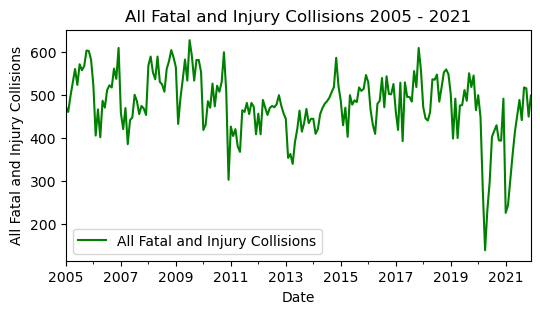

In [19]:
# Plot 

plot.style.use('default')
ax = df.plot(color='green', grid=False, figsize=(6,3))
ax.set_xlabel('Date')
ax.set_ylabel('All Fatal and Injury Collisions')
ax.set_title('All Fatal and Injury Collisions 2005 - 2021')
# Add a brown vertical line
# ax.axvline('2001-03-01', color='brown', linestyle='--')
# ax.axvline('2001-10-01', color='brown', linestyle='--')

# ax.axvline('2007-12-01', color='brown', linestyle='--')
# ax.axvline('2009-06-01', color='brown', linestyle='--')
plot.show()

<Axes: ylabel='Frequency'>

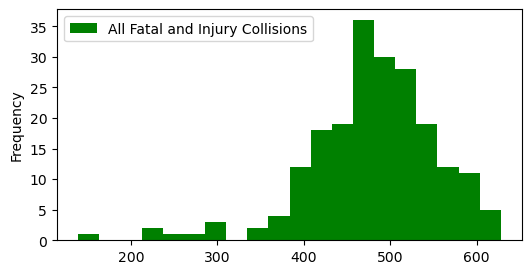

In [20]:
# Plot histogram (frequency of counts), change num of bins to see different plots
df.plot(kind='hist', bins=20, color='green',figsize=(6,3))

# frequency count of column 'Millions of Dollars' 
#count = furniture['Millions of Dollars'].value_counts()
#print(count)

<Axes: ylabel='Density'>

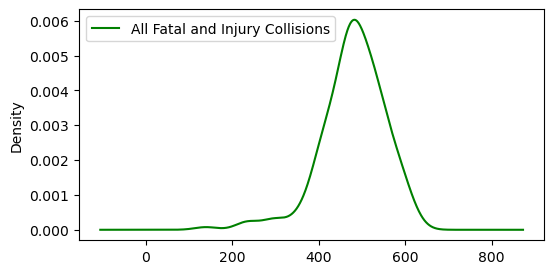

In [21]:
# Calculate kernel density plot
# A density plot shows the distribution of the data over a continuous interval. 
# Kernel density plot smoothes out the noise in time series data.
# The peaks of a density plot help display where values are concentrated over the interval.
# A Kernel density plot is a a better way to display the distribution because it's not affected by 
# the number of bins used (each bar used in a typical histogram).
df.plot(kind='kde', color="green", grid=False,figsize=(6,3))

Components of a Time Series
A time series is composed of mainly trend, seasonality, and noise. We will take a look at the component parts of a time series, focusing on automated decomposition methods. This will give you some intuition about the components of time series.

Trend
When we talk about trend, we are talking about how the series data increases or decreases over time. Is it moving higher or lower over the time frame? The series is either uptrend or downtrend, both of which are non-stationary.

Seasonality
Seasonality refers to a repeating periodic or cyclical pattern with regular intervals within a series. The pattern is within a fixed time period and it repeats itself at regular intervals. There can be upward or downward swings but it continues to repeat over a fixed period of time as in a cycle. Cyclicality could repeat but it has no fixed period.

Noise
In general, noise captures the irregularities or random variation in the series. It can have erratic events or simply random variation. It has a short duration. It is hard to predict due to its erratic occurrence.

Text(0.5, 1.0, 'All Fatal and Injury Collisions 2005 - 2021')

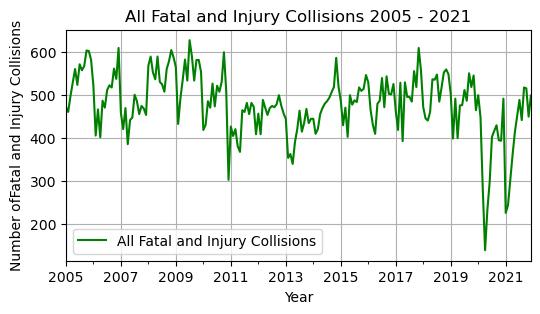

In [22]:
# Plot the time series 
plot.style.use('default')
ax = df.plot(color='green', grid=True, figsize=(6,3))
ax.set_xlabel('Year')
ax.set_ylabel('Number ofFatal and Injury Collisions')
ax.set_title('All Fatal and Injury Collisions 2005 - 2021')

In [23]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df['All Fatal and Injury Collisions'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.369084
p-value: 0.150653


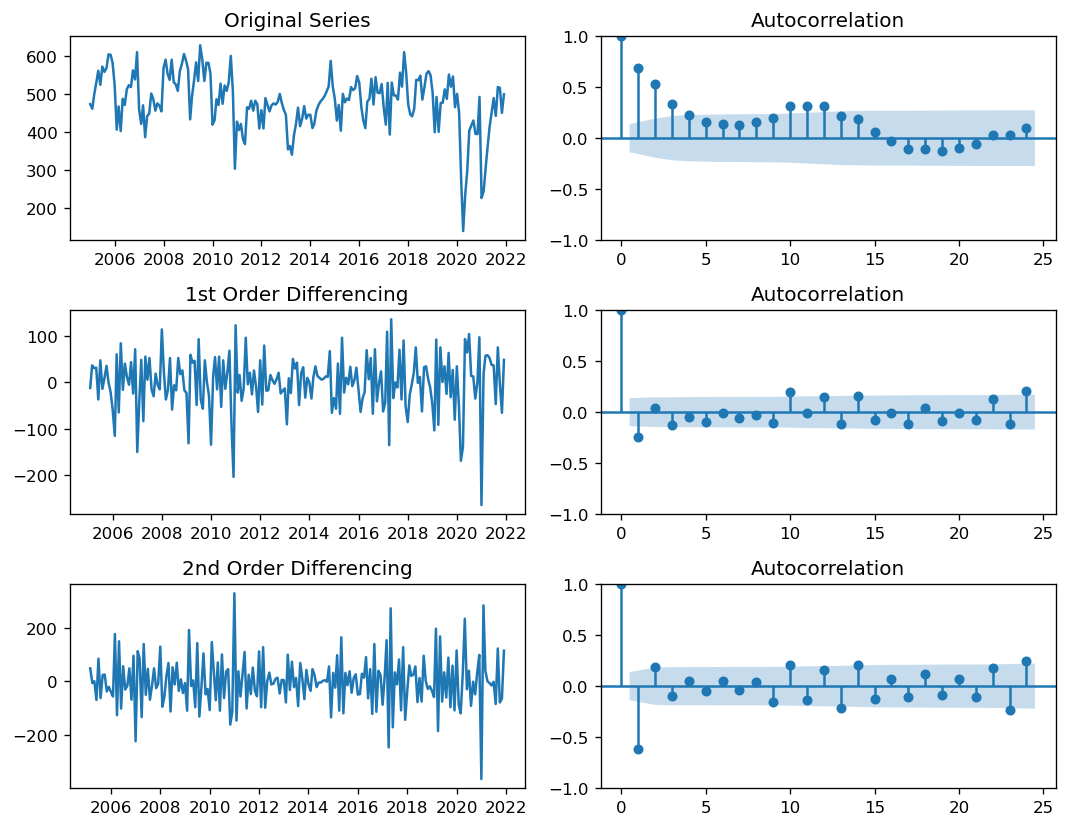

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])
plt.tight_layout() 
plt.show()

- The next step is to identify if the model needs any AR terms. We will find out the required number of AR terms by inspecting the **Partial Autocorrelation (PACF) plot**.


- **Partial autocorrelation** can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. This way, we will know if that lag is needed in the AR term or not.


- Partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.


$$Yt = \alpha0 + \alpha1 Y{t-1} + \alpha2 Y{t-2} + \alpha3 Y{t-3}$$


- That is, suppose, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient $\alpha_3$ of Y_t-3 in the above equation.


- Now, we should find the number of AR terms. Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.



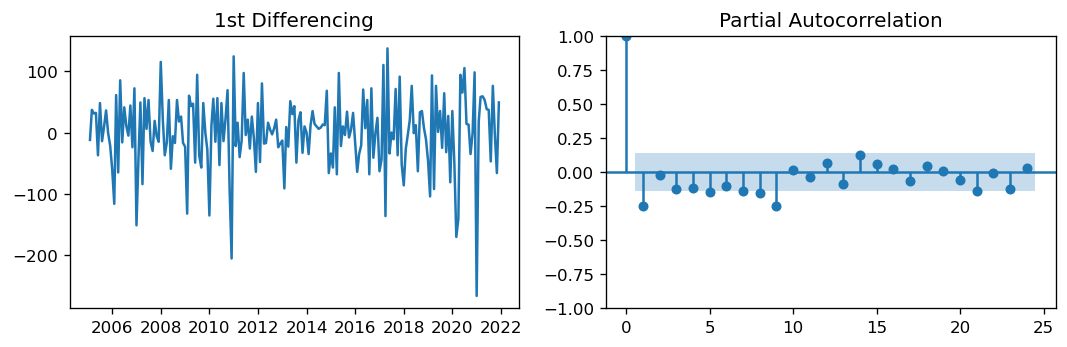

In [26]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])
plt.tight_layout() 
plt.show()

- We can see that the PACF lag 1 is quite significant since it is well above the significance line. So, we will fix the value of p as 1.

#  find the order of the MA term (q)** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)


- Just like how we looked at the PACF plot for the number of AR terms, we will look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.


- The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.


- Let’s see the autocorrelation plot of the differenced series.

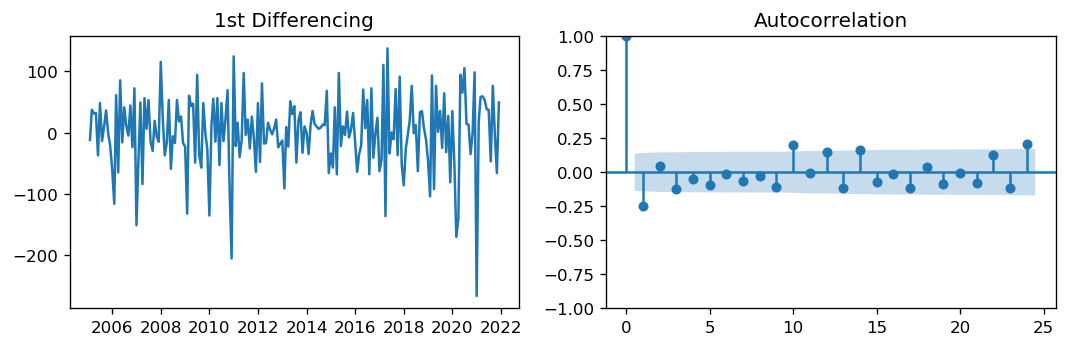

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.diff().dropna(), ax=axes[1])
plt.tight_layout() 
plt.show()

- We can see that couple of lags are well above the significance line. So, we will fix q as 2. If there is any doubt, we will go with the simpler model that sufficiently explains the Y.

# **8. How to handle if a time series is slightly under or over differenced** <a class="anchor" id="8"></a>

[Table of Contents](#0.1)


- It may happen that the time series is slightly under differenced. Differencing it one more time makes it slightly over-differenced. 


- If the series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, we will try adding an additional MA term.

# **9. How to build the ARIMA Model** <a class="anchor" id="9"></a>


[Table of Contents](#0.1)


Now, we have determined the values of p, d and q. We have everything needed to fit the ARIMA model. We will use the ARIMA() implementation in the statsmodels package.

In [28]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df['All Fatal and Injury Collisions'], order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:     All Fatal and Injury Collisions   No. Observations:                  204
Model:                              ARIMA(1, 1, 2)   Log Likelihood               -1099.017
Date:                             Fri, 15 Dec 2023   AIC                           2206.034
Time:                                     06:05:58   BIC                           2219.287
Sample:                                 01-01-2005   HQIC                          2211.396
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7240      0.106      6.815      0.000       0.516       0.932
ma.L1         -1.0873      

- The model summary provides lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

- The coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

- So, we will rebuild the model without the MA2 term.

In [29]:
# 1,1,1 ARIMA Model
model = ARIMA(df, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:     All Fatal and Injury Collisions   No. Observations:                  204
Model:                              ARIMA(1, 1, 1)   Log Likelihood               -1099.669
Date:                             Fri, 15 Dec 2023   AIC                           2205.338
Time:                                     06:06:01   BIC                           2215.278
Sample:                                 01-01-2005   HQIC                          2209.360
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6501      0.053     12.371      0.000       0.547       0.753
ma.L1         -0.9718      

C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


- The model AIC has slightly reduced, which is good. The p-values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

- Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

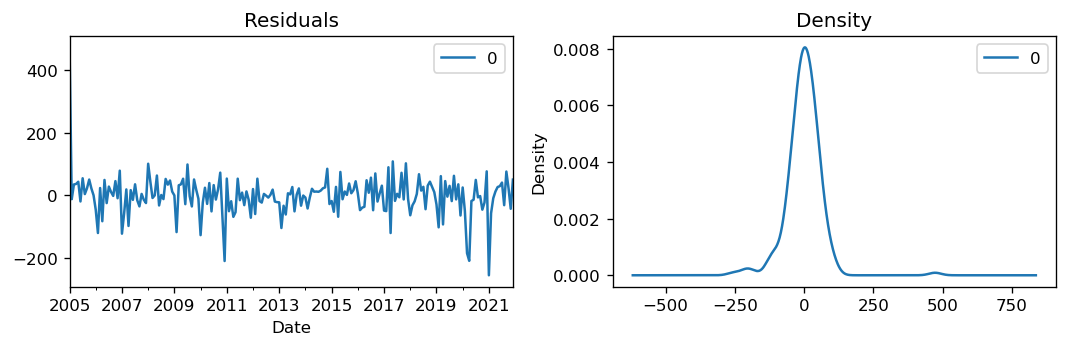

In [30]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout() 
plt.show()

- The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using **plot_predict()**.

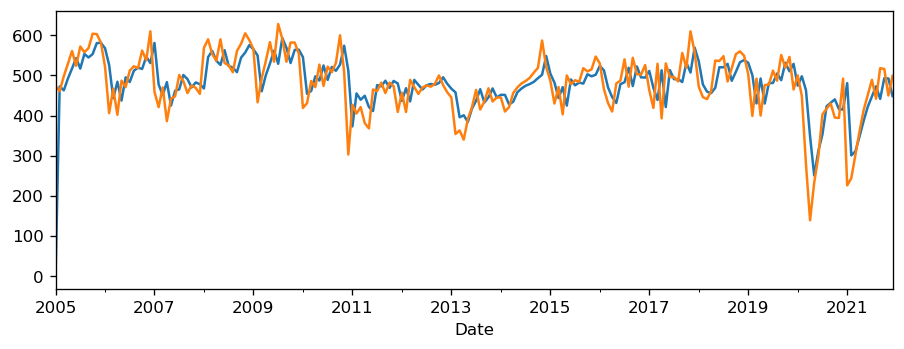

In [31]:
model_fit.predict(dynamic=False).plot()
df['All Fatal and Injury Collisions'].plot()
plt.show()

- When we set dynamic=False the in-sample lagged values are used for prediction. That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

- So, we seem to have a decent ARIMA model. But, we can’t say that this is the best ARIMA model because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

- So, the real validation we need now is the Out-of-Time cross-validation, discussed next.

# **10. Find the optimal ARIMA model using Out-of-Time Cross validation** <a class="anchor" id="10"></a>


[Table of Contents](#0.1)


- In Out-of-Time cross-validation, we move backwards in time and forecast into the future to as many steps we took back. Then we compare the forecast against the actuals. 

- To do so, we will create the training and testing dataset by splitting the time series into 2 contiguous parts in a reasonable proportion based on time frequency of series.

In [32]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df[:95]
test = df[95:]

- Now, we will build the ARIMA model on training dataset, forecast and plot it.

C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dmitri.iolchin\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:     All Fatal and Injury Collisions   No. Observations:                   95
Model:                              ARIMA(1, 1, 1)   Log Likelihood                -503.289
Date:                             Fri, 15 Dec 2023   AIC                           1012.577
Time:                                     06:58:18   BIC                           1020.207
Sample:                                 01-01-2005   HQIC                          1015.659
                                      - 11-01-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5861      0.133      4.412      0.000       0.326       0.846
ma.L1         -0.9580      

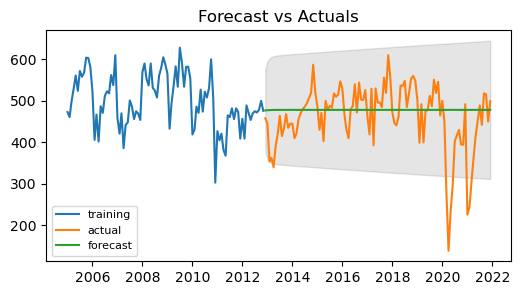

In [101]:
from statsmodels.tsa.arima.model import ARIMA

# Forecast the first AR(1) model
model = ARIMA(train, order=(1,1,1))
results  = model.fit()
PredictionResults = results.get_forecast(steps=109)
mean = PredictionResults.predicted_mean
conf = PredictionResults.conf_int(alpha=0.05)
print(results.summary())
upper = conf.iloc[:, 1]
lower = conf.iloc[:, 0]
# Plotdd
plt.figure(figsize=(6,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(mean, label='forecast')
plt.fill_between(lower.index, lower, upper, 
                 color='k', alpha=.1)
plt.title('Forecast vs Actuals')
plt.legend(loc='best', fontsize=8)
plt.show()

- From the above chart, the ARIMA(1,1,1) model seems to predict a correct forecast. The actual observed values lie within the 95% confidence band. 
- The P values of the AR and MA terms in the model summary is less than 0.05.

# **11. Accuracy Metrics for Time Series Forecast** <a class="anchor" id="11"></a>


[Table of Contents](#0.1)


The commonly used accuracy metrics to judge forecasts are:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Lag 1 Autocorrelation of Error (ACF1)
7. Correlation between the Actual and the Forecast (corr)
8. Min-Max Error (minmax)


Typically, we will use three accuracy metrices:-

1. MAPE
2. Correlation and 
3. Min-Max Error 


can be used. The above three are percentage errors that vary between 0 and 1. That way, we can judge how good is the forecast irrespective of the scale of the series.


In [110]:
actual = test.iloc[:, 0]
actual

Date
2012-12-01    458.0
2013-01-01    445.0
2013-02-01    354.0
2013-03-01    363.0
2013-04-01    340.0
              ...  
2021-08-01    442.0
2021-09-01    518.0
2021-10-01    516.0
2021-11-01    450.0
2021-12-01    499.0
Name: All Fatal and Injury Collisions, Length: 109, dtype: float64

In [115]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(mean-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(mean.values, actual.values)

{'mape': 0.1570979181830565,
 'me': 16.905293196717274,
 'mae': 55.39935553235073,
 'mpe': 0.08536512067127305,
 'rmse': 79.57363287985402,
 'acf1': 0.6867420373367611,
 'corr': 0.09264934560192191,
 'minmax': 0.11146967064721802}

Around 15.7% MAPE implies the model is about 84.3% accurate in predicting the next 15 observations. Now we know how to build an ARIMA model manually.

But, we should also know how to automate the best model selection process. So, we will discuss it next.

# **12. Auto Arima Forecasting in Python** <a class="anchor" id="12"></a>


[Table of Contents](#0.1)


- In Python, the `pmdarima` package provides `auto_arima()` function which can be used to automate the process of ARIMA Forecasting in Python.

- `auto_arima()` uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

- We need to install the `pmdarima` package first.

In [116]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/61/d3/68990f655b015afa9c10e8e0b88e6efc900d8f6f852322d33d20601e22d2/Cython-3.0.6-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   ------------------------------ --------- 471.0/614.7 kB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --------------- ------------------------ 1.0/2.8 MB 22.0 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.8 MB 27.8 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 29.4 MB/s eta 0:00:01
   ------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [118]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2239.014, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3104.202, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2874.886, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2222.503, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2223.207, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2240.202, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2214.377, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2213.816, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2265.541, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2213.345, Time=0

# **13. How to interpret the residual plots in ARIMA model** <a class="anchor" id="13"></a>


[Table of Contents](#0.1)

Let’s review the residual plots using stepwise_fit.

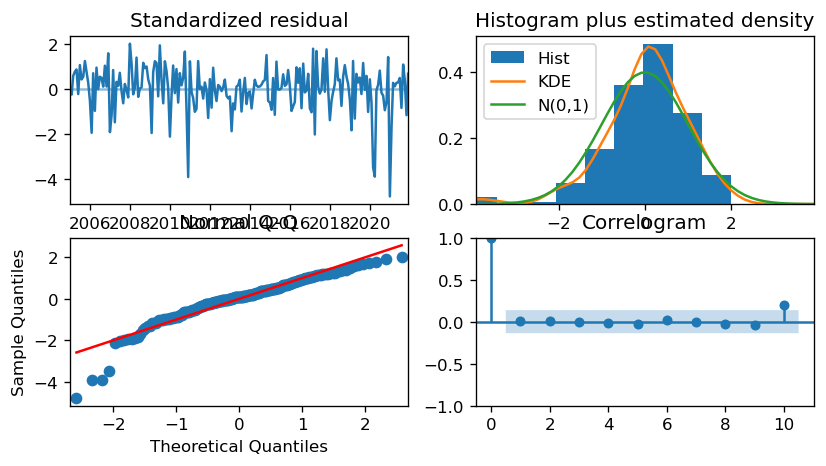

In [121]:
model.plot_diagnostics(figsize=(8,4))
plt.show()

## **Interpretation of plots in plot diagnostics**


**Standardized residual**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Histogram**: The density plot suggest normal distribution with mean slighlty shifted towards right.


**Theoretical Quantiles**: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Correlogram**: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.


Overall, the model seems to be a good fit. So, let's use it to forecast.

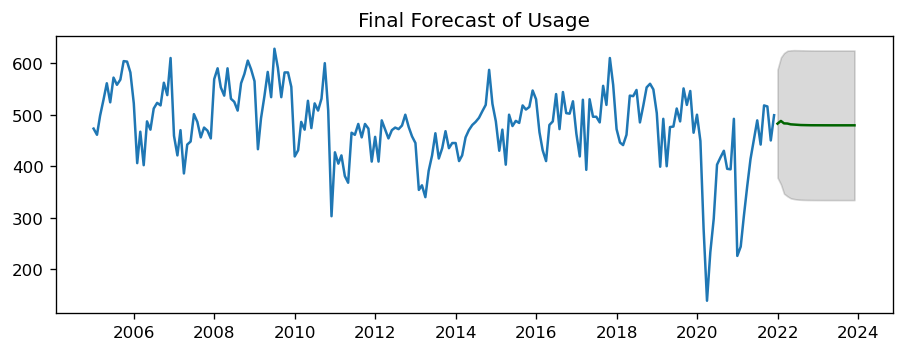

In [146]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.concatenate([df.index, fc.index])

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], fc.index)
upper_series = pd.Series(confint[:, 1], fc.index)

# Plot
plt.plot(df)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()